### non-linear forecasting of monkey ECoG data during awake resting and anesthesia
0. calculate delay time, T, of maximal independence
    - try autocorrelation and MI (and random delays)
1. determine embedded dimension of the data
2. use nearest neighbors to predict
3. compare with linear prediction techniques
4. see how the above varies for condition, topography, and analysis parameter
5. see how data length affects embedding dimension

extensions:
- calculate other non-linear forecasting quantities, e.g. Hurst exponent, fractal dimension, etc
- how to use the spatial dimension for multivariate forecasting?
- can reconstructed attractor from one channel make predictions for other channels

tips:
- try first difference, filter out oscillations

In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import math as math
import random 
import statsmodels.tsa.stattools as sm
from scipy import integrate
import dynamical.nonlinear as nl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'

In [694]:
channel = 1
session = 1
data_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'

matfile = io.loadmat(data_path +'Session' +str(session) + '/ECoG_ch' + str(channel) +'.mat', squeeze_me=True)
timefile = io.loadmat(data_path + 'Session' +str(session) + '/Condition.mat', squeeze_me=True)
ecog = matfile['ECoGData_ch'+str(channel)]
data = ecog[timefile['ConditionIndex'][0]:timefile['ConditionIndex'][1]]

### experiment 1a:
how does bin size of the histogram influence the calculation of mutual information?
we obviously don't want MI to be influenced by an arbitrary parameter choice, so cycle through a few bin sizes to test whether it plays a significant role.
###### conclusion:
bin size influences the absolute value of the MI calculation, but does so in a consistent way for all time delays such that the minimum is still reliably retrieved.

In [707]:
max_tau = 200
MI = np.zeros((max_tau, 4))
num_bins = [20, 50, 100, 200]
for idx, bs in enumerate(num_bins):
    print bs,
    MI[:,idx] = nl.delay_MI(data[110000:120000],bs,max_tau)

20 50 100 200


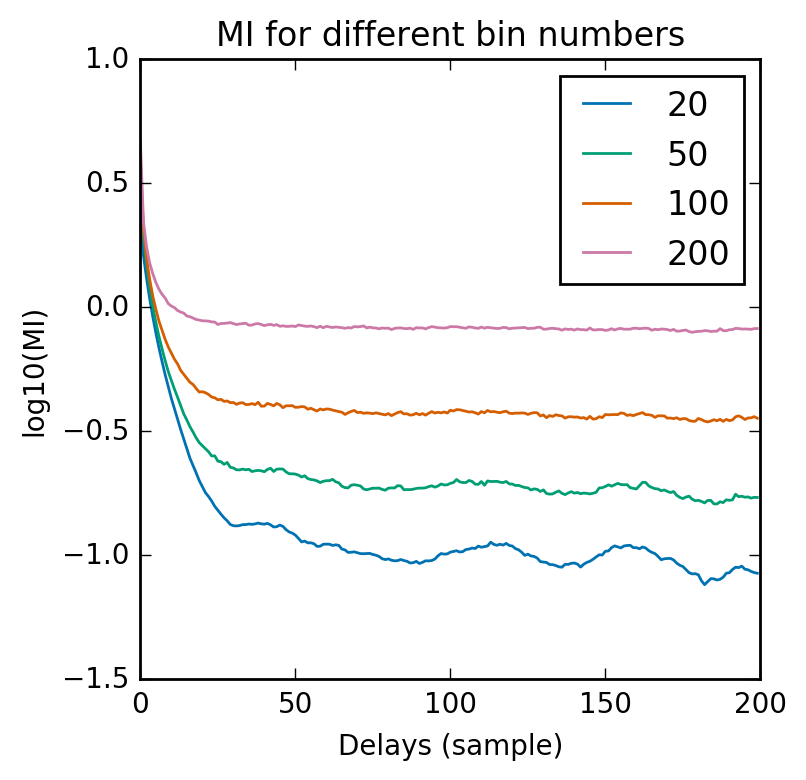

In [708]:
plt.figure(figsize=(4,4))
plt.plot(np.log10(MI))
plt.legend((num_bins))
plt.xlabel('Delays (sample)')
plt.ylabel('log10(MI)')
plt.title('MI for different bin numbers');

In [369]:
nbins = 50
L = len(data)
M1 = nl.delay_MI(data[:120000], nbins, max_tau=200)
#M2 = nl.delay_MI(data[L/2:], nbins, max_tau=200)

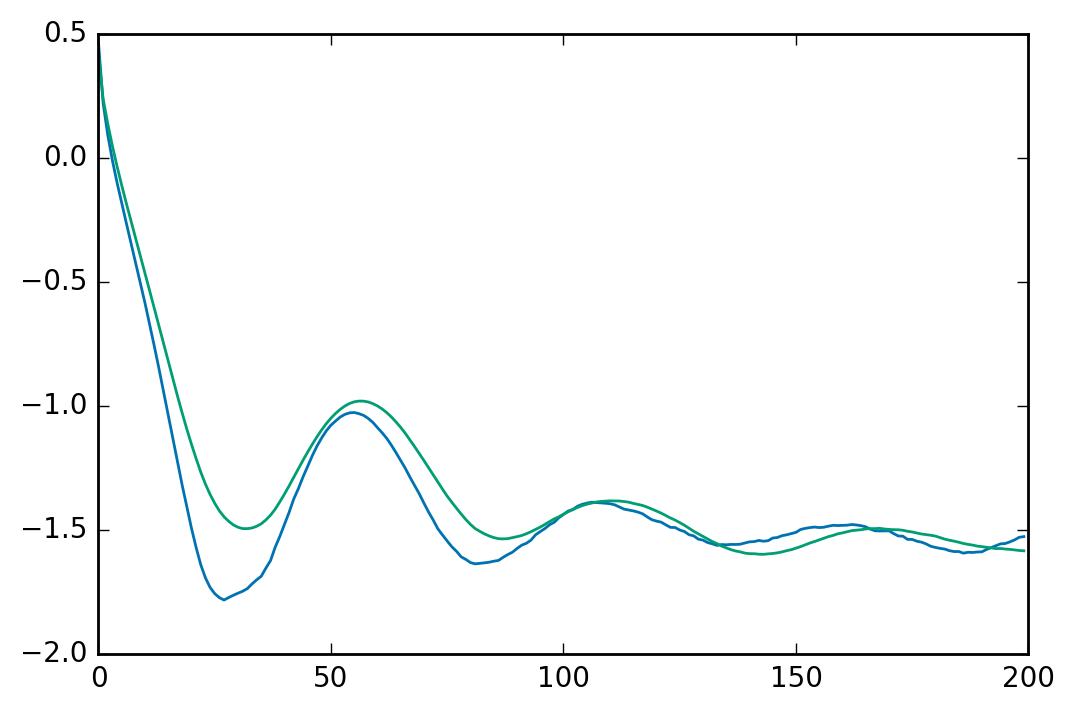

In [370]:
plt.plot(np.log10(M1))
plt.plot(np.log10(M2))

In [219]:
nbins = 50
L = len(data)
M1 = nl.delay_MI(data, nbins, max_tau)
M2 = nl.delay_MI(np.diff(data), nbins, max_tau)

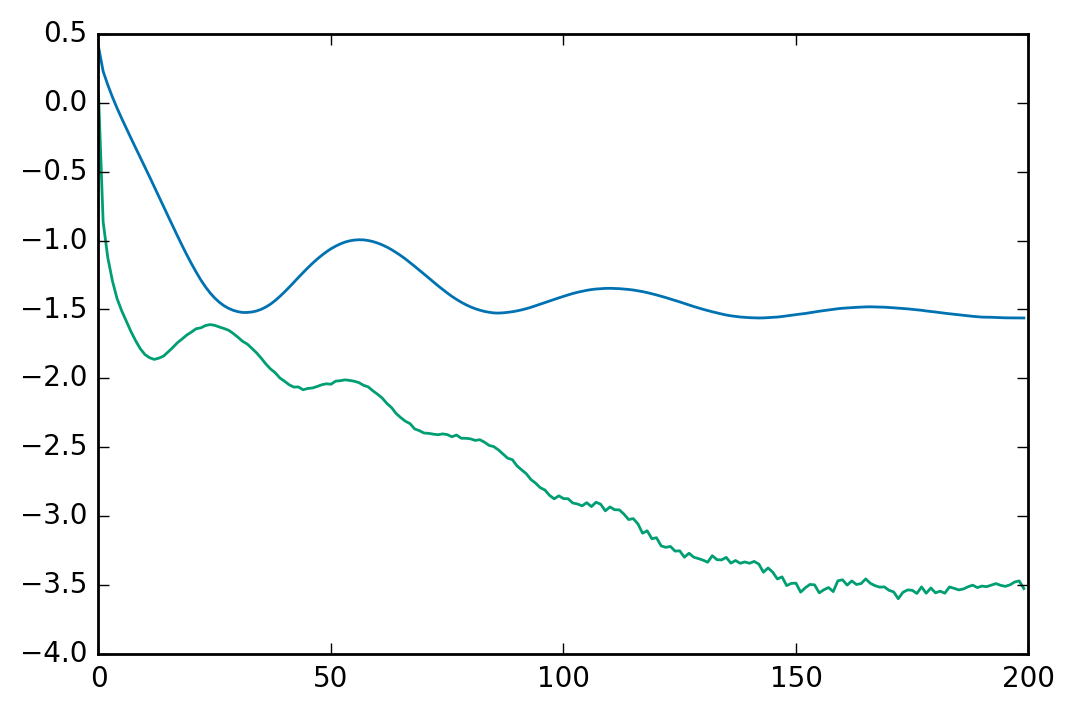

In [220]:
plt.plot(np.log10(M1))
plt.plot(np.log10(M2))

In [508]:
%%time
#reload(nl)

nbins = 50
max_tau = 100
max_dim = 7
pffn_thr = 0.01 # thresh for attractor dimension with this cutoff
R_thr = 15. # thresh for nn distance gained in new dim
A_thr = 2. # thresh for relative nn distance to attractor size
params = {'nbins': nbins, 
          'max_tau': max_tau, 
          'max_dim': max_dim, 
          'pffn_thr': pffn_thr,
          'R_thr': R_thr, 
          'A_thr': A_thr}

data_seg = data[30000:60000:2]
MI = nl.delay_MI(data_seg, nbins, max_tau)
opt_tau, min_mi = nl.first_valley(MI)
del_R, attr_size, nn_Rsq, nn_idx = nl.nn_embed_dist(data_seg, opt_tau, max_dim)
attr_dim, pffn = nl.nn_attractor_dim(del_R, attr_size, pffn_thr, R_thr, A_thr)
result = {'MI': MI,
           'tau': opt_tau,
           'del_R': del_R,
           'attr_size' :attr_size,
           'attr_dim' :attr_dim,
           'pffn': pffn, 
           'params': params}

print len(data_seg)

Dim: 1 2 3 4 5 6 7 15000
CPU times: user 7.57 s, sys: 668 ms, total: 8.23 s
Wall time: 8.31 s


### main experiment
first, divide data of each condition, downsample to 500Hz, then divide into N chunks (N=4-8 depending on time)
compute dimensionality across these N time points for all conditions and save data for each channel

In [684]:
reload(nl)
def chunk_analysis(data_seg):
    nbins = 50
    max_tau = 250
    max_dim = 7
    pffn_thr = 0.01 # thresh for attractor dimension with this cutoff
    R_thr = 15. # thresh for nn distance gained in new dim
    A_thr = 2. # thresh for relative nn distance to attractor size
    params = {'nbins': nbins, 
              'max_tau': max_tau, 
              'max_dim': max_dim, 
              'pffn_thr': pffn_thr,
              'R_thr': R_thr, 
              'A_thr': A_thr}

    MI = nl.delay_MI(data_seg, nbins, max_tau)
    opt_tau, min_mi = nl.first_valley(MI)
    del_R, attr_size, nn_Rsq, nn_idx = nl.nn_embed_dist(data_seg, opt_tau, max_dim)
    attr_dim, pffn = nl.nn_attractor_dim(del_R, attr_size, pffn_thr, R_thr, A_thr)
    result = {'MI': MI,
               'tau': opt_tau,
               'del_R': del_R,
               'attr_size' :attr_size,
               'attr_dim' :attr_dim,
               'pffn': pffn, 
               'params': params}

    return result

### run analysis on raw data

In [710]:
data_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'
result_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/5k_delay_embed_res/'
# data division
channels = np.append(np.arange(1,63), np.arange(64,129))
#15k points at 500Hz (downsampled) is 30seconds
seg_len = 5000
#skip the first 10s of data
skip_len = 5000
data_conds = [[0,2],[0,1,3]]
N_chks = 10


#loop through channels
for channel in channels:
    #aggregated result for channel
    results = []
    print 'Chan: ', channel
    #loop through sessions
    for session in range(1,3):
        print 'Session:', session
        timefile = io.loadmat(data_path + 'Session' +str(session) + '/Condition.mat', squeeze_me=True)
        matfile = io.loadmat(data_path +'Session' +str(session) + '/ECoG_ch' + str(channel) +'.mat', squeeze_me=True)
        ecog = matfile['ECoGData_ch'+str(channel)]
        for cond in data_conds[session-1]:
            cond_idx = timefile['ConditionIndex'][cond:cond+2]
            data = sig.decimate(ecog[cond_idx[0]:cond_idx[1]], 2, zero_phase=True)
            seg_inds = skip_len+np.arange(0,N_chks,dtype='int')*len(data)/N_chks
            for seg in seg_inds:
                data_seg = data[seg:seg+seg_len]
                result = chunk_analysis(data_seg)
                results.append(result)
            
    # save result for channel
    sp.io.savemat(result_path+'DE_chan'+str(channel)+'.mat', {'results':results})                
    print '---'        

Chan:  1
Session: 1
Session: 2
---
Chan:  2
Session: 1
Session: 2
---
Chan:  3
Session: 1
Session: 2
---
Chan:  4
Session: 1
Session: 2
---
Chan:  5
Session: 1
Session: 2
---
Chan:  6
Session: 1
Session: 2
---
Chan:  7
Session: 1
Session: 2
---
Chan:  8
Session: 1
Session: 2
---
Chan:  9
Session: 1
Session: 2
---
Chan:  10
Session: 1
Session: 2
---
Chan:  11
Session: 1
Session: 2
---
Chan:  12
Session: 1
Session: 2
---
Chan:  13
Session: 1
Session: 2
---
Chan:  14
Session: 1
Session: 2
---
Chan:  15
Session: 1
Session: 2
---
Chan:  16
Session: 1
Session: 2
---
Chan:  17
Session: 1
Session: 2
---
Chan:  18
Session: 1
Session: 2
---
Chan:  19
Session: 1
Session: 2
---
Chan:  20
Session: 1
Session: 2
---
Chan:  21
Session: 1
Session: 2
---
Chan:  22
Session: 1
Session: 2
---
Chan:  23
Session: 1
Session: 2
---
Chan:  24
Session: 1
Session: 2
---
Chan:  25
Session: 1
Session: 2
---
Chan:  26
Session: 1
Session: 2
---
Chan:  27
Session: 1
Session: 2
---
Chan:  28
Session: 1
Session: 2
---
C

### analysis on first difference

In [691]:
data_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'
result_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/5k_delay_embed_diff_res/'
# data division
channels = np.append(np.arange(1,63), np.arange(64,129))
#15k points at 500Hz (downsampled) is 30seconds
seg_len = 5000
#skip the first 10s of data
skip_len = 5000
data_conds = [[0,2],[0,1,3]]
N_chks = 10


#loop through channels
for channel in channels:
    #aggregated result for channel
    results = []
    print 'Chan: ', channel
    #loop through sessions
    for session in range(1,3):
        #print 'Session:', session
        timefile = io.loadmat(data_path + 'Session' +str(session) + '/Condition.mat', squeeze_me=True)
        matfile = io.loadmat(data_path +'Session' +str(session) + '/ECoG_ch' + str(channel) +'.mat', squeeze_me=True)
        ecog = matfile['ECoGData_ch'+str(channel)]
        for cond in data_conds[session-1]:
            cond_idx = timefile['ConditionIndex'][cond:cond+2]
            data = sig.decimate(ecog[cond_idx[0]:cond_idx[1]], 2, zero_phase=True)
            seg_inds = skip_len+np.arange(0,N_chks,dtype='int')*len(data)/N_chks
            for seg in seg_inds:
                data_seg = np.diff(data[seg:seg+seg_len])
                result = chunk_analysis(data_seg)
                results.append(result)
            
    # save result for channel
    sp.io.savemat(result_path+'DE_chan'+str(channel)+'.mat', {'results':results})                
    print '---'        

Chan:  1
---
Chan:  2
---
Chan:  3
---
Chan:  4
---
Chan:  5
---
Chan:  6
---
Chan:  7
---
Chan:  8
---
Chan:  9
---
Chan:  10
---
Chan:  11
---
Chan:  12
---
Chan:  13
---
Chan:  14
---
Chan:  15
---
Chan:  16
---
Chan:  17
---
Chan:  18
---
Chan:  19
---
Chan:  20
---
Chan:  21
---
Chan:  22
---
Chan:  23
---
Chan:  24
---
Chan:  25
---
Chan:  26
---
Chan:  27
---
Chan:  28
---
Chan:  29
---
Chan:  30
---
Chan:  31
---
Chan:  32
---
Chan:  33
---
Chan:  34
---
Chan:  35
---
Chan:  36
---
Chan:  37
---
Chan:  38
---
Chan:  39
---
Chan:  40
---
Chan:  41
---
Chan:  42
---
Chan:  43
---
Chan:  44
---
Chan:  45
---
Chan:  46
---
Chan:  47
---
Chan:  48
---
Chan:  49
---
Chan:  50
---
Chan:  51
---
Chan:  52
---
Chan:  53
---
Chan:  54
---
Chan:  55
---
Chan:  56
---
Chan:  57
---
Chan:  58
---
Chan:  59
---
Chan:  60
---
Chan:  61
---
Chan:  62
---
Chan:  64
---
Chan:  65
---
Chan:  66
---
Chan:  67
---
Chan:  68
---
Chan:  69
---
Chan:  70
---
Chan:  71
---
Chan:  72
---
Chan:  73
---
C